# Programming Exercise 4, Hidden Markov Model

The goal of this task is to learn about the how to implement the Hidden Markov Model, especially the Viterbi algorithm.
Then use the model to do smoothing and make predictions

The coronavirus is spreading in Munich and threatening our health. In this exercise, we would like to model the spread of the virus using an HMM model. For this purpose, we set 7 states of pandemic severity (1 for least severe, 7 for most severe). Then, we collect the corona data from April 2020 to December 2021 (21 months in total) and compute the number of new cases and deaths for each month as our observation. Based on this, our task is to find the most likely severity sequence using the Viterbi algorithm, do smoothing, and make a prediction about the severity of future pandemics.

Your tasks is to complete the missing code. Make sure that all the functions follow the provided interfaces of the functions, i.e. the output of the function exactly matches the description in the docstring.
Adding or modifying code outside of the following comment blocks is not required:

```
##########################################################
# YOUR CODE HERE
.....
##########################################################
```

### Learning Outcomes:

* implement prior matrix, transition model, sensor model
* implement viterbi algorithm

### Import

For testing and grading, we want to state that you are not allowed to import 
any other libraries and should not change the structure of the provided functions 
(i.a. the arguments and the name of the functions).

In [1]:
import branca.colormap as cmap
import folium
from folium.plugins import TimeSliderChoropleth
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

### Corona data visualization (Nothing to implement here)

Before we start to model the corona situation, we would like to visualize the data first to have a basic understanding of it. Feel free to change some parameters to achieve different visualization settings. Have fun!

In [2]:
# load the corona data
corona_df = pd.read_csv('coronadata_Munich.csv')
munich_map_df = gpd.read_file('map/vg2500_krs.shp')

In [3]:
# check what munich_map_df looks like
munich_map_df

,USE,RS,RS_ALT,GEN,SHAPE_LENG,SHAPE_AREA,geometry
0,4,01001,010010000000,Flensburg,32467.034276,5.324899e+07,"POLYGON ((9.48982 54.82296, 9.50467 54.81004, ..."
1,4,01002,010020000000,Kiel,73027.302434,1.218654e+08,"POLYGON ((10.19057 54.38909, 10.18370 54.38910..."
2,4,01003,010030000000,Lübeck,104861.094220,2.211386e+08,"POLYGON ((10.89297 53.95695, 10.90337 53.95705..."
3,4,01004,010040000000,Neumünster,39858.818376,8.092363e+07,"POLYGON ((10.03454 54.12915, 10.02277 54.10938..."
4,4,01051,010510000000,Dithmarschen,202206.675707,1.450311e+09,"MULTIPOLYGON (((9.05176 54.36640, 9.07193 54.3..."
...,...,...,...,...,...,...,...
397,4,16073,160730000000,Saalfeld-Rudolstadt,209670.746788,1.023057e+09,"POLYGON ((11.42397 50.80862, 11.42072 50.80306..."
398,4,16074,160740000000,Saale-Holzland-Kreis,172686.880125,8.176883e+08,"POLYGON ((12.01807 50.96757, 12.02085 50.94806..."
399,4,16075,160750000000,Saale-Orla-Kreis,185679.957051,1.144877e+09,"POLYGON ((11.94482 50.59236, 11.92423 50.58608..."
400,4,16076,160760000000,Greiz,222979.605428,8.509542e+08,"POLYGON ((12.22219 50.94284, 12.23787 50.92905..."


In [4]:
# We only need the GEN and geometry columns
munich_map_df = munich_map_df[['GEN', 'geometry']]

# Only keep Munich and LK Munich
munich_map_df = munich_map_df.loc[[224, 239]]
munich_map_df['GEN'] = ['Munich','LK Munich']

In [5]:
# check what corona_df looks like
corona_df

,GEN,ObservationDate,Confirmed,Deaths
0,Munich,2020-04-01T17:00:00+0000,70.2,118.25
1,Munich,2020-04-02T17:00:00+0000,69.4,115.36
2,Munich,2020-04-03T17:00:00+0000,65.3,117.45
3,Munich,2020-04-04T17:00:00+0000,64.4,115.58
4,Munich,2020-04-05T17:00:00+0000,68.2,118.12
...,...,...,...,...
1275,LK Munich,2021-12-27T17:00:00+0000,198.1,0.00
1276,LK Munich,2021-12-28T17:00:00+0000,195.7,0.00
1277,LK Munich,2021-12-29T17:00:00+0000,193.7,0.00
1278,LK Munich,2021-12-30T17:00:00+0000,192.1,0.00


In [6]:
# Both dataframes have the column "GEN", we merge them using this column
joined_df = corona_df.merge(munich_map_df, on='GEN')

# The ObservationDate is given in date and time, we convert it to unix time in nanoseconds
joined_df['date_sec'] = pd.to_datetime(joined_df['ObservationDate']).astype(np.int64) / 10**9
joined_df['date_sec'] = joined_df['date_sec'].astype(int).astype(str)

# Delete the ObservationDate column as we do not need it anymore
joined_df = joined_df.drop('ObservationDate', axis = 1)

# Check the final dataframe before we do the visualization
joined_df

C:\Users\10122\AppData\Local\Temp/ipykernel_17684/1179517000.py:5: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  joined_df['date_sec'] = pd.to_datetime(joined_df['ObservationDate']).astype(np.int64) / 10**9


,GEN,Confirmed,Deaths,geometry,date_sec
0,Munich,70.2,118.25,"POLYGON ((11.55265 48.22802, 11.55420 48.22292...",1585760400
1,Munich,69.4,115.36,"POLYGON ((11.55265 48.22802, 11.55420 48.22292...",1585846800
2,Munich,65.3,117.45,"POLYGON ((11.55265 48.22802, 11.55420 48.22292...",1585933200
3,Munich,64.4,115.58,"POLYGON ((11.55265 48.22802, 11.55420 48.22292...",1586019600
4,Munich,68.2,118.12,"POLYGON ((11.55265 48.22802, 11.55420 48.22292...",1586106000
...,...,...,...,...,...
1275,LK Munich,198.1,0.00,"POLYGON ((11.58252 48.29474, 11.59326 48.28478...",1640624400
1276,LK Munich,195.7,0.00,"POLYGON ((11.58252 48.29474, 11.59326 48.28478...",1640710800
1277,LK Munich,193.7,0.00,"POLYGON ((11.58252 48.29474, 11.59326 48.28478...",1640797200
1278,LK Munich,192.1,0.00,"POLYGON ((11.58252 48.29474, 11.59326 48.28478...",1640883600


In [30]:
## Here, we visualize the daily confirmed case
# Add the color to each row
max_colour = max(joined_df['Confirmed'])
min_colour = min(joined_df['Confirmed'])
colour_map = cmap.linear.YlOrRd_09.scale(min_colour, max_colour)
joined_df['colour'] = joined_df['Confirmed'].map(colour_map)

# uncomment the following code to visualize daily death cases
#max_colour = max(joined_df['Deaths'])
#min_colour = min(joined_df['Deaths'])
#colour_map = cmap.linear.YlOrRd_09.scale(min_colour, max_colour)
#joined_df['colour'] = joined_df['Deaths'].map(colour_map)

# create an inner dictionary for the visualization
geo_list = joined_df['GEN'].unique().tolist()
geo_idx = range(len(geo_list))

style_dict = {}
for i in geo_idx:
    geo = geo_list[i]
    result = joined_df[joined_df['GEN'] == geo]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict

# create a geo_gdf for the visualization
geo_df = joined_df[['geometry']]
geo_gdf = gpd.GeoDataFrame(geo_df)
geo_gdf = geo_gdf.drop_duplicates().reset_index()

#You might need to change the value of min_zoom depending on your platform
slider_map = folium.Map(location=[48.08,11.61], min_zoom=2, max_bounds=True)

_ = TimeSliderChoropleth(data=geo_gdf.to_json(),styledict=style_dict).add_to(slider_map)
_ = colour_map.add_to(slider_map)
colour_map.caption = "confirmed cases in the past 7 days per 100,000 people"

## uncomment for the death cases
#colour_map.caption = "death cases in the past 7 days per 5,000,000 people"

## uncomment the following code to save the figure
#slider_map.save(outfile='daily_confirmed_case.html')
#slider_map.save(outfile='daily_death_case.html')

In [31]:
# final visualization, drag the bar to see the statistics on different days
slider_map

### Build the HMM model

In our HMM model, there are two observations: confirmed cases per 100,000 people and death cases per 5,000,000 people. Unlike the umbrella case in our textbook, our data is continuous, which means we need a continuous HMM model. But don't worry! The transition from a discrete HMM model to a continuous one is easy. In this task, you are only supposed to implement a discrete model.

Let's define a class named HMM that is able to execute filtering, smoothing, prediction and the most likely path estimation based on discrete observation data. You will implement the aforementioned functions step by step within the **HMM** class. Vectorized operation given in the textbook will be very useful for during implementation.

**Note: During implementation, we refer the state with their associated indices.** For example, as defined in the textbook, the ij-th entry of transition matrix denotes the transformation probability from state j to state i.

In [9]:
def dict_to_array(state_dict):
    state_array = [state_dict[t] for t in sorted(state_dict.keys())]        
    return np.array(state_array) 

class HMM():
    def __init__(self, 
                 observation_mu,
                 observation_sigma,
                 transition_matrix, 
                 initial_probability):
        assert len(transition_matrix) == len(observation_mu) == len(observation_sigma)
        self.trans_mat = transition_matrix
        self.obs_mat = [multivariate_normal(observation_mu[i], observation_sigma[i]) 
                        for i in range(len(observation_mu))]
        self.init_prob = initial_probability
        self.N_state = len(self.trans_mat)        
        
    def compute_observation_matrix(self, observation):
        """ Compute the observation matrix for vectorized operation.
       
        Args:
            observation: observation in some timestamp

        Return: 
            O_matrix: observation matrix

        """
        prob_density = [self.obs_mat[i].pdf(observation) for i in range(self.N_state)]
        O_matrix = np.diag(prob_density)
        return O_matrix


    def forward_onestep(self, f, observation):
        """ Compute one forward step for filtering.
            N stands for number of hidden states.
            Hint: Use the O_matrix we provided for one step forward oepration.

        Args:
            f: numpy array with shape [N, ], vector of f_{1:t} depicting probability of state given previous observation sequence
            observation: observed state in timestamp t+1
            

        Return: 
            f_onestep: numpy array with shape [N, ], updated vector of f_{1:t+1}

        """
        # Acquire the row vector and transform it to diagonal matrix
        O_matrix = self.compute_observation_matrix(observation)
        f_onestep = None
        #######################################
        # YOUR CODE HERE
        f_onestep = O_matrix @ self.trans_mat @ f
        #######################################
        return f_onestep
        
        
    def backward_onestep(self, b, observation):
        """ Compute one backward step for smoothing 
            N stands for number of hidden states. 
            Hint: Use the O_matrix we provided for one step backward.

        Args:
            b: numpy array with shape [N, ], vector of b_{k+2:T} depicting probability of observation sequence given state
            observation: observed state in timestamp k+1
            
        Return: 
            b_onestep: numpy array with shape [N, ], updated vector of b_{k+1:T}

        """
        # Acquire the row vector and transform it to diagonal matrix
        O_matrix = self.compute_observation_matrix(observation)
        b_onestep = None
        #######################################
        # YOUR CODE HERE
        b_onestep = self.trans_mat.T @ O_matrix @ b
        #######################################
        return b_onestep
        
        
    def forward_backward(self, observation_sequence):
        """ forward-backward algorithm for smoothing
            In this function, you will finalize the forward-backward algorithm based on your previous implementaions
            of function “forward_onestep” and "backward_onestep".
            
            Remember to normalize the result smoothed probabilty to ensure the probability sum to be 1! 
            Note: We provide normalization function as a reference, you can also implement your own :)
       
            T stands for sequence lenghth and N stands for number of hidden states.

        Args:
            observation_sequence: observed sequence in a given period with length T
            

        Return: 
            smoothed_prob: numpy array with shape [T, N], state probability in this period after smoothing.

        """
        forward_prob = {}
        smoothed_prob = {}
        backward_prob = {}
        #######################################
        # YOUR CODE HERE
        
        # Initialize the parameters
        T = len(observation_sequence)
        forward_prob[0] = self.init_prob
        backward_prob[T+1] = np.ones(self.N_state)
        
        for i in range(0, T, 1):
            forward_prob[i+1] = self.forward_onestep(forward_prob[i], observation_sequence[i])
        
        for i in range(T, 0, -1):
            smoothed_prob[i] = self.normalize(forward_prob[i] * backward_prob[i+1])
            backward_prob[i] = self.backward_onestep(backward_prob[i+1], observation_sequence[i-1])
            
        #######################################
        return dict_to_array(smoothed_prob)

        
    def predict(self, observation_sequence, k):
        """ Predict state probability for future timestamp, remember to filter the given observation sequence at first.
            
            Remember to normalize the result forward probabilty to ensure the probability sum to be 1! 
            Note: We provide normalization function as a reference, you can also implement your own :)
            
            N stands for number of hidden states.

        Args:
            observation_sequence: observed sequence in a given period with length T
            k: the number of steps of timestamp T
            
        Return: 
            p: numpy array with shape [N, ], vector of state probability after k steps of timestamp T in the future
             
        """
        #######################################
        # YOUR CODE HERE
        forward_prob = {}
        pred_history = {}

        # Initialize the parameters
        T = len(observation_sequence)
        forward_prob[0] = self.init_prob
        
        # Calculate forward variable f_{1:t}
        for i in range(0, T, 1):
            forward_prob[i+1] = self.forward_onestep(forward_prob[i], observation_sequence[i])
            
        # Predict
        p = self.normalize(forward_prob[T])
        for i in range(k):
            p = self.trans_mat @ p
            pred_history[i] = p

        #######################################
        return p
        

    def viterbi(self, observation_sequence):
        """ Compute the most likely state trajectory given a observation sequence.
            T stands for sequence lenghth.

        Args:
            observation_sequence: observed sequence in a given period with length T
            
        Return: 
            trajectory: numpy array with shape [T, ], trajectory of the most likely state in the given period.
            Note that the output trajectory is in the form of the corresponding indices of the states. For example,
            the output with numpy array [1, 7, 5] denotes given a sequence with lenghth T=3, the most likely state 
            trasnforms from state 1 to state 7 and finally to state 5.
        """
        max_prob = {}
        most_likely_state = {}
        trajectory = {}
        #######################################
        # YOUR CODE HERE
        
        T = len(observation_sequence)
        
        # Initialization with filering
        start_time = 1
        max_prob[start_time] = self.forward_onestep(self.init_prob, observation_sequence[start_time-1])
        
        # Compute probability
        for i in range(start_time+1, T+1):
            
            # Acquire the probability and current observation
            prob = self.trans_mat * max_prob[i-1][np.newaxis] # N x N

            # Keep track of the most likely state
            most_likely_state[i-1] = np.argmax(prob, axis = 1)
            
            # Compute the maximum probability
            observation = observation_sequence[i-1]
            observation_prob = np.diagonal(self.compute_observation_matrix(observation))
            max_logit =  observation_prob * np.amax(prob, axis = 1)
            
            # Normalize the probability
            max_prob[i] = self.normalize(max_logit)
               
        
        # Initialize the trajectory and do back-tracking
        trajectory[T] = np.argmax(max_prob[T])
        
        for i in range(T-1, 0, -1):
            trajectory[i] = most_likely_state[i][trajectory[i+1]]

        #######################################
        return dict_to_array(trajectory)

    @staticmethod
    def normalize(logit, axis=0):
        prob = logit / np.sum(logit, axis=axis)
        return prob 

### Test Your Implementations

Let's run your implemented functions with some dummy data.

**Please DON'T change the pre-defined parameters below!**

In [10]:
# Pre-defined model parameters for HMM testing
# Input transition matrix, NxN matrix in our scenario (N states)
T = np.array([[0.2, 0.6],
              [0.8, 0.4]])

# Input mean of gaussian variable here, Nx2 matrix in our scenario,
# Since each state has its own corresponding gaussian distribution (N states), and the dimension of the observation is H.
# For each H-dimensional gaussian distribution, its corresponding mean (mu) vector shall has H dimension.
# So we input 7xH matrix as *mus* in our scenario.
mus = np.array([[0.8, 0.7], 
                [0.3, 0.2]])

# Input mean of gaussian variable here, NxHxH matrix in our scenario,
# Since each state has its own corresponding gaussian distribution (N states), and the dimension of the observation is H.
# For each H-dimensional gaussian distribution, its corresponding covariance matrix (sigma) shall be HxH.
# So we input NxHxH matrix as *sigmas* in our scenario.
sigmas = np.zeros((2, 2, 2))
sigmas[0] = np.eye(2)
sigmas[1] = np.eye(2)

# Input initialized state distribution here, a vector with N dimension. (N states)
init_prob = np.array([0.3, 0.7])

In [11]:
from utils import test_hmm

# Initialize your implemented HMM model!
hmm = HMM(mus, sigmas, T, init_prob) 

# Test each implemenation module :)
test_hmm('forward_backward', hmm)    
test_hmm('prediction', hmm)    
test_hmm('viterbi', hmm)   

Congratulations! Your implementation passed all testing examples for forward_backward test!
Congratulations! Your implementation passed all testing examples for prediction test!
[[0.01341631 0.04147646]
 [0.05366524 0.02765098]]
[[0.19317076 0.02048773]
 [0.77268303 0.01365849]]
[1 0 0]
[1 0 0]
[[0.01206455 0.04080996]
 [0.04825819 0.02720664]]
[[0.0775092  0.36747241]
 [0.31003679 0.24498161]]
[1 0 1]
[1 0 1]
[[0.01520267 0.03660285]
 [0.06081068 0.0244019 ]]
[[0.08965517 0.33103448]
 [0.35862069 0.22068966]]
[0 1 0]
[0 1 0]
Congratulations! Your implementation passed all testing examples for viterbi test!


### Apply HMM for COVID Severity Estimation

In this section, your final task is to use the use HMM model for COVID severity estimation as a guide for examination decision-makers. 

You may refer to this [paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9543670) to better understand the how we can leverage HMM to model the spread progress of COVID given some observation data such as daily and cumulative infections and daily deaths. (This paper will only appear here and not in the final version.)

In this task, we define the following components of HMM as follows:

```
Hidden State: Severity of the COVID, there are 7 discrete levels in total and the transition diagram is shown in below.
Observation: A 7 * 2 matrix (mus) and a 7 * 2 * 2 matrix (sigmas)
Transformation Model: A 7 * 7 matrix that depicts the internal relationship between each state.
Sensor Model: A 2-dimensional gaussian distribution based on given state.
```

It can be a little bit tricky since in this scenario the sensor model is modeled as a continuous probability density distribution instead of a discrete matrix as discussed during lectures. While don't be panic since we have  provided you a helper function to extract the diagonal observation matrix (O_matrix), and then the algorithm for filtering, smoothing and viterbi will be just the same as the discrete case we dealt with during class ;) 

We will provide pre-estimated HMM parameters for you such as transformation matrix and preprocessed data, let's now take a look on how we use HMM to model COVID :)

### Transitional Matrix

We define the transitional matrix as the following figure shows:
![title](img/transitional_matrix.png)

In [12]:
#######################################
# T is a 7 * 7 matrix, T(ij) means the probability from state i to state j

# YOUR CODE HERE

T = np.array([[0.989, 0.002, 0.008, 0.000, 0.000, 0.000, 0.000],
              [0.004, 0.984, 0.005, 0.004, 0.004, 0.000, 0.000],
              [0.007, 0.002, 0.977, 0.009, 0.000, 0.000, 0.000],
              [0.000, 0.007, 0.010, 0.973, 0.006, 0.000, 0.009],
              [0.000, 0.005, 0.000, 0.009, 0.977, 0.014, 0.004],
              [0.000, 0.000, 0.000, 0.000, 0.010, 0.981, 0.003],
              [0.000, 0.000, 0.000, 0.005, 0.003, 0.005, 0.984]])

#######################################

### Observation Matrix

We define the observational matrix as the following figure shows:
<img src='img/observational_matrix.png'  width='35%'  height='35%'>

In [13]:
#######################################
# mus is a 7 * 2 matrix, which indicates the input mean of gaussian variable
# sigmas is a 7 * 2 * 2 matrix, which indicates the input covariance of gaussian variable. Each state has a 2 * 2 covariance matrix

# YOUR CODE HERE

mus = np.array([[0.000, 2.842],
                [7.105, 43.526],
                [8.365, 5.425],
                [54.292, 35.294],
                [123.655, 150.556],
                [255.332, 390.887],
                [331.681, 162.652]])


sigmas = np.zeros((7, 2, 2))
sigmas[0] = np.array([[0.049, 0], 
                      [0, 14.896]])
sigmas[1] = np.array([[41.209, 16.856], 
                      [16.856, 664.93]])
sigmas[2] = np.array([[39.984, 11.417], 
                      [11.417, 12.691]])
sigmas[3] = np.array([[658.07, 310.464], 
                      [310.464, 430.269]])
sigmas[4] = np.array([[3584.35, 1716.96], 
                      [1716.96, 2281.93]])
sigmas[5] = np.array([[28086.8, 17875.2],
                      [17875.2, 19007.1]])
sigmas[6] = np.array([[26891.2, 15268.4],
                      [15268.4, 14259]])

#######################################

### Initialized State Distribution (Nothing to do here)

In [14]:
# init_prob is a 7-dimensional vector
init_prob = np.array([0.414, 0, 0.401, 0.137, 0, 0, 0.047])

### Obsevation Sequence

Since we take into account 21 months in total, the sequence is a 21 * 2 matrix which contains both confirmed cases and death cases.

**The sequence can be found in sequence.csv**

In [15]:
#######################################
# obsevation sequence is a 21 * 2 matrix containing both confirmed cases and death cases, here, we define 2 sequences, one for Munich,
# one for LK_Munich

# YOUR CODE HERE

obs_seq_Munich = np.array([[183, 358], 
                           [45, 54],
                           [24, 1],
                           [34, 0], 
                           [110, 0],
                           [191, 14],
                           [415, 124], 
                           [914, 708],
                           [969, 1282],
                           [507, 559], 
                           [166, 114],
                           [371, 160],
                           [601, 208], 
                           [278, 115],
                           [70, 5],
                           [96, 0], 
                           [273, 73],
                           [537, 165],
                           [743, 207], 
                           [1730, 462],
                           [1149, 149]])

obs_seq_LK_Munich = np.array([[178, 587], 
                              [34, 18],
                              [9, 0],
                              [20, 0], 
                              [58, 0],
                              [101, 0],
                              [361, 4], 
                              [790, 416],
                              [767, 917],
                              [491, 590], 
                              [241, 166],
                              [341, 6],
                              [550, 0], 
                              [245, 0],
                              [44, 0],
                              [65, 0], 
                              [191, 20],
                              [391, 22],
                              [563, 0], 
                              [1734, 26],
                              [1119, 32]])

#######################################

### Testing (Nothing to do here)

In [16]:
# Test Forward-backward algorithm
hmm = HMM(mus, sigmas, T, init_prob)
smoothed_prob_Munich = hmm.forward_backward(obs_seq_Munich)
smoothed_prob_LK_Munich = hmm.forward_backward(obs_seq_LK_Munich)
print('smoothed_prob_Munich: \n', smoothed_prob_Munich, '\n')
print('smoothed_prob_LK_Munich: \n', smoothed_prob_LK_Munich, '\n')

# Test Prediction
predicted_prob_Munich = hmm.predict(obs_seq_Munich, 10)
predicted_prob_LK_Munich = hmm.predict(obs_seq_LK_Munich, 10)
print('prediction_Munich: \n', predicted_prob_Munich, '\n')
print('prediction_LK_Munich: \n', predicted_prob_LK_Munich, '\n')


# Test viterbi algorithm
trajectory_Munich = hmm.viterbi(obs_seq_Munich)
trajectory_LK_Munich = hmm.viterbi(obs_seq_LK_Munich)
print('trajectory_Munich: \n',trajectory_Munich, '\n')
print('trajectory_LK_Munich: \n',trajectory_LK_Munich, '\n')

smoothed_prob_Munich: 
 [[0.00000000e+000 0.00000000e+000 0.00000000e+000 1.21965405e-051
  1.57894543e-003 6.55670913e-003 9.91864345e-001]
 [0.00000000e+000 1.41209495e-012 1.37188195e-094 7.87716310e-001
  2.31574156e-003 5.86743701e-004 2.09381205e-001]
 [0.00000000e+000 1.69778606e-006 4.68440085e-006 8.02285355e-001
  5.35543626e-005 2.34510659e-005 1.97631257e-001]
 [0.00000000e+000 6.61463353e-011 3.50887023e-012 7.79448808e-001
  2.87295192e-005 8.02978109e-007 2.20521660e-001]
 [0.00000000e+000 5.16447461e-065 4.84674657e-095 7.24306909e-003
  5.15207578e-005 2.24556013e-008 9.92705388e-001]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 7.17559202e-013
  4.28907343e-008 1.69365699e-007 9.99999788e-001]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 3.86821101e-052
  7.83028043e-011 1.38017577e-004 9.99861982e-001]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  8.40323502e-041 8.63239397e-001 1.36760603e-001]
 [0.00000000e+000 0.00000000e+000 0.0000

Answer:

trajectory_Munich: 

[6 3 3 3 6 6 6 5 5 5 6 6 6 6 6 6 6 6 6 6 6]

trajectory_LK_Munich:

[5 6 6 6 6 6 6 6 5 5 6 6 6 6 6 6 6 6 6 6 6] 

Text(0.5, 1.0, 'Severity of COVID-19 in LK Munich')

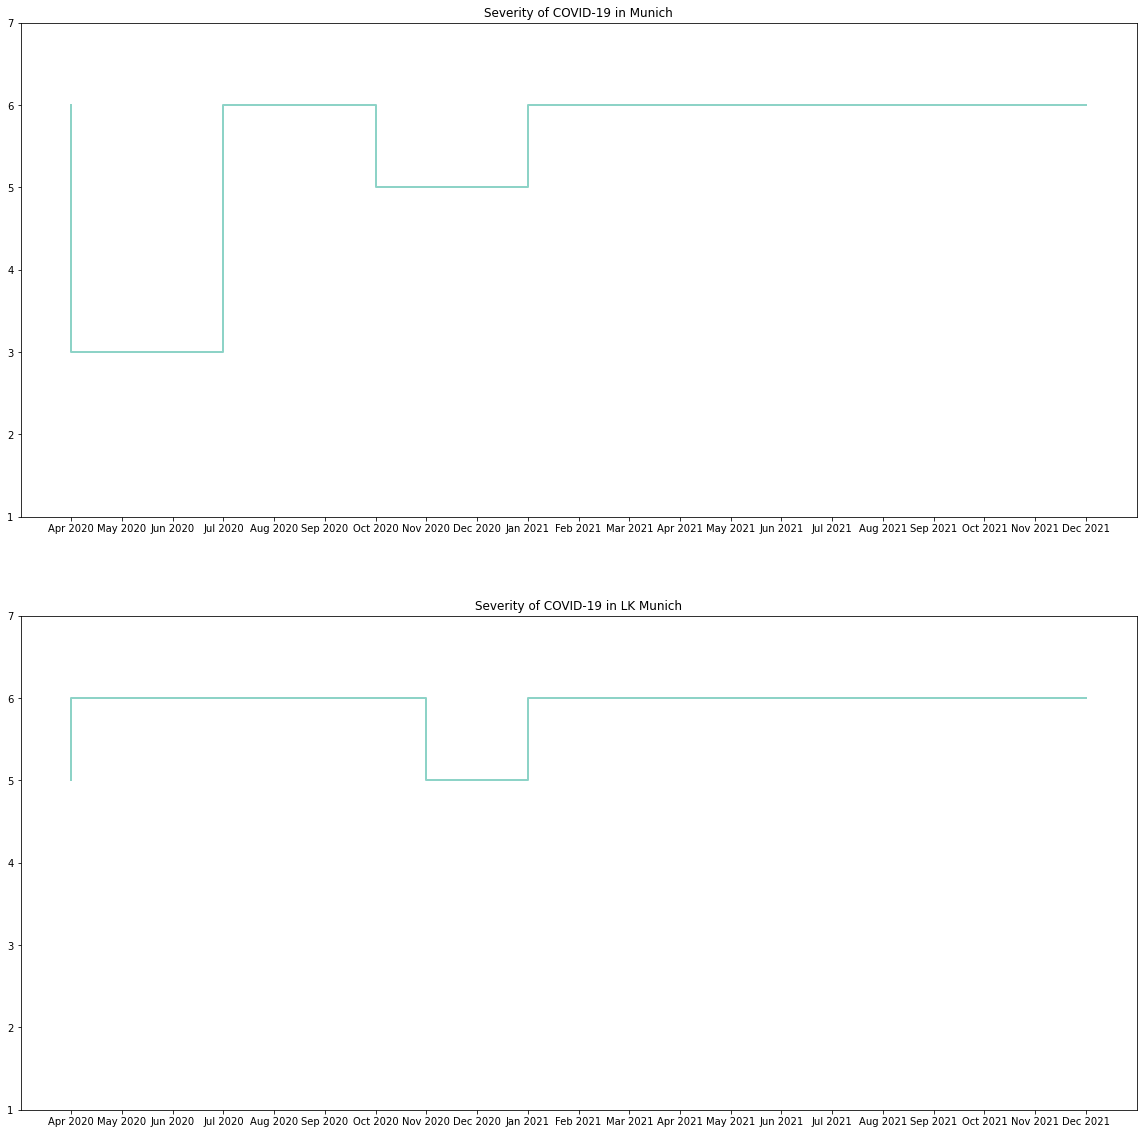

In [24]:
#visualize the result in plt

months = ['Apr 2020', 'May 2020', 'Jun 2020', 'Jul 2020', 'Aug 2020', 'Sep 2020', 'Oct 2020','Nov 2020', \
          'Dec 2020', 'Jan 2021', 'Feb 2021', 'Mar 2021', 'Apr 2021', 'May 2021', 'Jun 2021','Jul 2021', \
          'Aug 2021', 'Sep 2021', 'Oct 2021', 'Nov 2021', 'Dec 2021']

plt.figure(figsize=(20,20))

#Munich
plt.subplot(2, 1, 1)
fig_Munich = plt.step(months, trajectory_Munich, color="#8dd3c7", where="pre", lw=2)
plt.ylim(1, 7)
plt.title('Severity of COVID-19 in Munich')

#LK_Munich
plt.subplot(2, 1, 2)
fig_LK_Munich = plt.step(months, trajectory_LK_Munich, color="#8dd3c7", where="pre", lw=2)
plt.ylim(1, 7)
plt.title('Severity of COVID-19 in LK Munich')

In [21]:
#visualize the result in DataFrame
data = [months, list(trajectory_Munich), list(trajectory_LK_Munich)]
df = pd.DataFrame(np.transpose(data), columns=['Months', 'Munich','LK_Munich'])

df

,Months,Munich,LK_Munich
0,Apr 2020,6,5
1,May 2020,3,6
2,Jun 2020,3,6
3,Jul 2020,3,6
4,Aug 2020,6,6
5,Sep 2020,6,6
6,Oct 2020,6,6
7,Nov 2020,5,6
8,Dec 2020,5,5
9,Jan 2021,5,5
